<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import clear_output

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

Чтобы быстро длилась эпоха, сделаем как в дз по сегментации, а именно каждую картинку перекинем в list, и сделаем DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:
zip_file='/content/drive/MyDrive/faces_dataset_small.zip'
z=zipfile.ZipFile(zip_file,'r')
z.extractall()
print (os.listdir())

['.config', 'faces_dataset_small', '__MACOSX', 'drive', 'sample_data']


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
data_dir='/content/faces_dataset_small/'

In [ ]:
!mkdir faces

In [ ]:
import shutil
for img in os.listdir(data_dir):
  shutil.move(data_dir+img,'/content/faces')

In [ ]:
os.remove('/content/faces/.DS_Store')

In [ ]:
from skimage.io import imread
from skimage.transform import resize
size=(64,64)
images=[]
for root, dirs, files in os.walk('/content/faces'):
  for img in tqdm(files):
    images.append(resize(imread('/content/faces/'+img),size, mode='constant', anti_aliasing=True))
  break

  0%|          | 0/3143 [00:00<?, ?it/s]

In [ ]:
images=torch.tensor(images)
images=images.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [ ]:
train_dl = DataLoader(list(np.rollaxis(images, 3, 1)), 
                     batch_size=64, shuffle=True)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images.cpu(), nmax)
        break

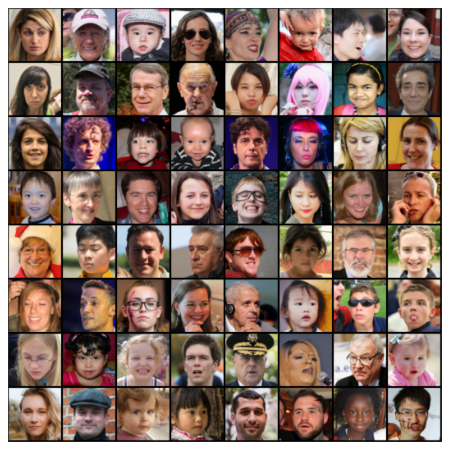

In [ ]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 512 x 512

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    


    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
latent_size = 128  # choose latent size

generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Sigmoid()
    # out: 3 x 64 x 64
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def fit(model, criterion, epochs, lr):
    batch_size=64
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_dl):
            real_images=real_images.to(device).float()
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        clear_output(wait=True)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        
        xb = torch.randn(batch_size, latent_size, 1, 1) 
        fake_images = model['generator'](xb.cuda())
        show_images(fake_images.cpu())
        
        plt.figure(figsize=(15, 6))
        plt.plot(losses_d, '-')
        plt.plot(losses_g, '-')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Discriminator', 'Generator'])
        plt.title('Losses')
        
        plt.figure(figsize=(15, 6))
        plt.plot(real_scores, '-')
        plt.plot(fake_scores, '-')
        plt.xlabel('epoch')
        plt.ylabel('score')
        plt.legend(['Real', 'Fake'])
        plt.title('Scores');
        plt.show()
    

Epoch [150/150], loss_g: 4.3474, loss_d: 0.1815, real_score: 0.9287, fake_score: 0.0743


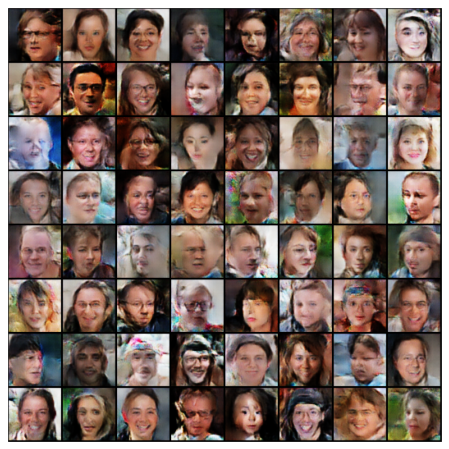

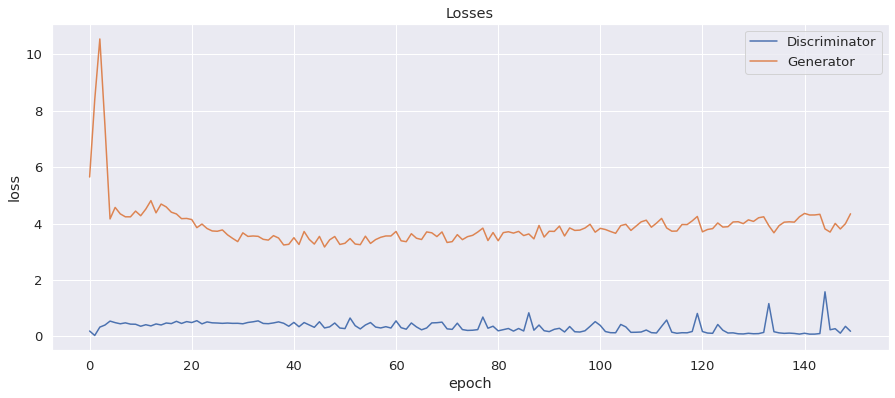

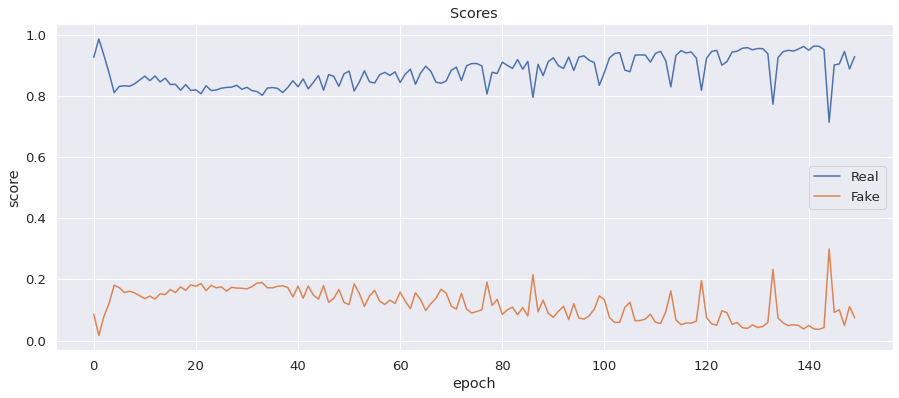

In [ ]:
fit(model,criterion,150,lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images =64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

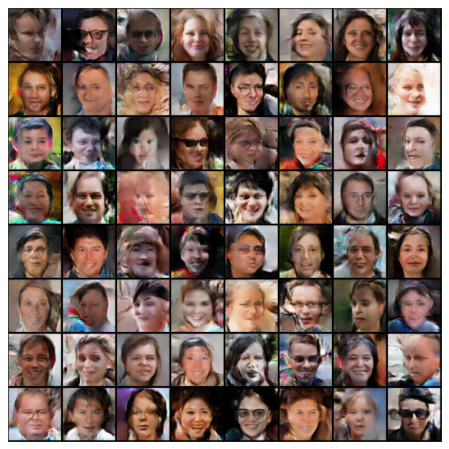

In [ ]:
show_images(fake_images.detach().cpu())

Как вам качество получившихся изображений?

Страшные :)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
n_images = 3143

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
y_ones=torch.ones(3143)
y_zeros=torch.zeros(3143)
y=torch.cat((y_ones,y_zeros),dim=0)

In [ ]:
X=torch.cat((torch.tensor(images).view(3143,-1),fake_images.view(3143,-1).detach().cpu()),dim=0)

Чтобы ускорить процесс, используем PCA с 100 главных компонент

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(100)
X_pca=pca.fit_transform(X)

In [ ]:
clf=KNeighborsClassifier(n_neighbors=1)
cross_val_score(clf, X_pca, y, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1).mean()

0.999522748965956

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

мда.. Хуже не придумать :) Ну что тут сказать? Результат получился очень плохой, т.к. классификатор различает фейковые и настоящие изображения, идеально получать accuracy 0.5, т.к. это показывает, что классификатор не различает изображения

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
X_tsne=TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_pca)

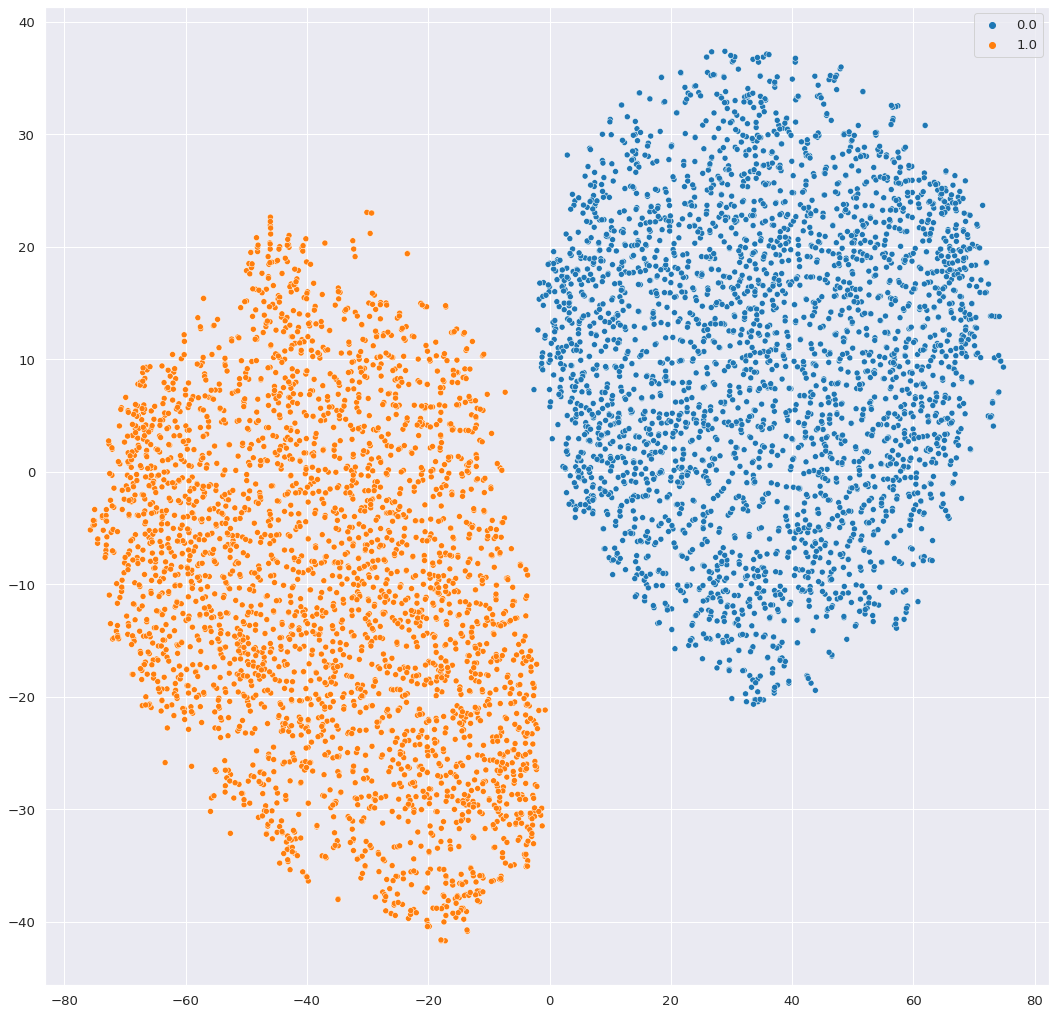

In [ ]:
plt.figure(figsize=(18, 18))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, 
                    palette="tab10")
plt.show()

Прокомментируйте получившийся результат:

Впринцепи, что и следовало ожидать, 2 класса в пространстве $R^2$ идеально различимы, соответственно мой GAN плохо решил данную задачу, т.к. облака точек в хорошем GANе должны накладываться друг на друга 

P.S. Надеюсь за плохое качество не будут сниматься баллы :)